# Five-dimensional artificial example with strong interactions

An artificial dataset is created from 5 features with relatively strong interactions compared to the linear terms.

The feature interactions are compared with Friedman's H-statistic, both the regular an the non-normalized version.

In [1]:
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt

from explainpolysvm import expsvm

from sklearn.model_selection import train_test_split
from sklearn.inspection import partial_dependence
from sklearn.svm import SVC
import skexplain
from scipy.interpolate import interpn, interp1d

In [ ]:
save_figs = False

Fit Scikit-learn SVC model using a quadratic polynomial kernel and manually set hyperparameters.

Samples changed class due to noise: 3.8%


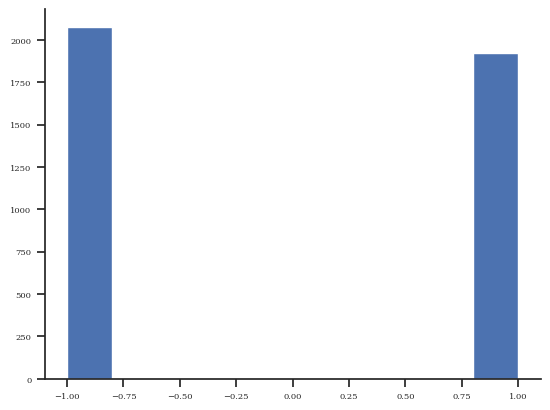

In [3]:
n_feat = 5
n_samples = 4000
rng = np.random.default_rng(1011)

# Class labels
def class_fun(X, sigma, rng):
    return 0.5*X[:,0]*X[:,1] - 0.5*X[:,0]*X[:,2] - 0.15*X[:,3]**2 + 0.1*np.sum(X, axis=1)  + rng.normal(0, sigma, (X.shape[0]))

# Noisy class assignment
def dec_fun(X, noise_std, rng):
    return 2*(class_fun(X, noise_std, rng) > -1) - 1

def sample_points(n_samples, n_feat, rng, noise_std=1):
    X = 10*(rng.random((n_samples, n_feat)) - 0.5)
    y = dec_fun(X, noise_std, rng)
    return X, y

X, y = sample_points(n_samples, n_feat, rng, noise_std=0.4)

# Test how many samples changed class due to noise
y_nn = dec_fun(X, 0, rng)
print(f'Samples changed class due to noise: {100*np.sum(y!=y_nn)/len(y):.1f}%')

y_p1 = y == 1
y_m1 = y == -1

plt.figure()
plt.hist(y)
plt.show()


In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2000, random_state=10)
n_train = X_train.shape[0]
# Fit SVM
C = 1
degree = 3
gamma = 'scale'
r = np.sqrt(2)

# Fit SVM
kernel = 'poly'
model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, coef0=r, probability=True)
model.fit(X_train, y_train)

sv = model.support_vectors_
dual_coef = np.squeeze(model.dual_coef_)
intercept = model.intercept_[0]
kernel_gamma = model._gamma

# Calculate and time ExPSVM explanations
t_start = time.time()
es = expsvm.ExPSVM(sv=sv, dual_coef=dual_coef, intercept=intercept,
                kernel_d=degree, kernel_r=r, kernel_gamma=kernel_gamma)
es.transform_svm()
print(f'Time for ExPSVM explanations: {time.time() - t_start:.3e}s')

Time for ExPSVM explanations: 1.016e-03s


Test performance

In [5]:
y_pred = np.sign(es.decision_function(x=X_test))
acc_test = np.sum(y_pred==y_test)/y_test.size
print('Test accuracy: {}'.format(acc_test))

Test accuracy: 0.9565


In [6]:
print('Number of interactions excl. intercept:', len(es.feature_importance(include_intercept=False)[0]))

Number of interactions excl. intercept: 55


Feature importance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


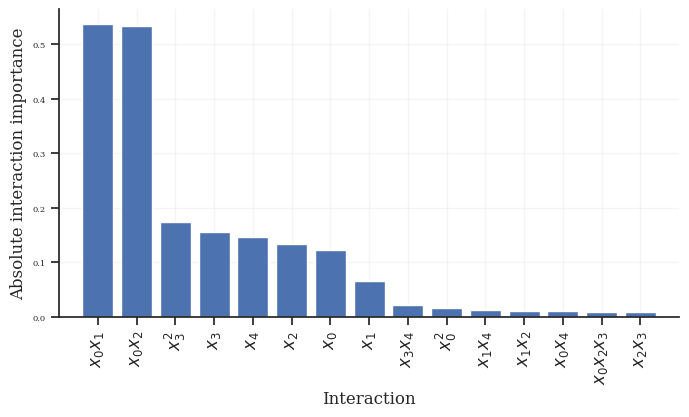

In [7]:
fig = es.plot_model_bar(n_features=15, magnitude=True, figsize=(8,4), show=False)
fig.gca().set_title('')
fig.gca().set_ylabel('Absolute interaction importance')
fig.gca().tick_params(axis='x', which='major', labelsize=12)
plt.grid(alpha=0.2)
if save_figs:
    plt.savefig('./images/feature_importance_artificial_strong_1dpd.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/feature_importance_artificial_strong_1dpd.eps', bbox_inches='tight', facecolor='white')
plt.show()

Plot evolution of interaction importance with respect to C.

In [8]:
lin_feat = [f'{ind}' for ind in np.arange(n_feat)]
quad_feat = [f'{t[0]},{t[1]}' for t in list(itertools.combinations_with_replacement(lin_feat, r=2))]
cube_feat = [f'{t[0]},{t[1]},{t[2]}' for t in list(itertools.combinations_with_replacement(lin_feat, r=3))]
all_feat = ['intercept'] + lin_feat + quad_feat + cube_feat
n_top = len(all_feat)

def top_imp(X, y, C, kernel, degree, gamma, coef0, X_test, y_test):
    model_tmp = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, coef0=coef0)
    model_tmp.fit(X, y)

    sv = model_tmp.support_vectors_
    dual_coef = np.squeeze(model_tmp.dual_coef_)
    intercept = model_tmp.intercept_[0]
    kernel_gamma = model_tmp._gamma

    es = expsvm.ExPSVM(sv=sv, dual_coef=dual_coef, intercept=intercept,
                    kernel_d=degree, kernel_r=r, kernel_gamma=kernel_gamma)
    es.transform_svm()

    y_pred = np.sign(es.decision_function(x=X_test))
    acc = np.sum(y_pred==y_test)/y_test.size

    # Calculate
    imp, imp_f, _ = es.feature_importance(include_intercept=True, format_names=False, sort=False)
    return imp, imp_f, acc


# Retrain for various values for C. Takes about 10 minutes.
study_c_dependence = False
if study_c_dependence:
    Cs = np.power(10., np.arange(-6, 6))
    top_imps = np.zeros((len(Cs), n_top))
    accs = np.zeros(len(Cs))

    # Retrain SVM for each C, evaluate accuracy on test set each time.
    for ind, c in enumerate(Cs):
        x_train_tmp, y_train_tmp = sample_points(2000, 6, rng, 1)
        imp, _, acc = top_imp(x_train_tmp, y_train_tmp, c, kernel, degree, gamma, r, X_test, y_test)
        top_imps[ind, :] = imp
        accs[ind] = acc

        top_imps_rel = top_imps/np.max(top_imps, axis=1, keepdims=True)

In [9]:
if study_c_dependence:
    plt.figure()
    # Plot accuracy
    plt.plot(Cs, accs, color='k', linestyle='--', label='Accuracy')
    known_imp_f = ['3', '0,1', '0,2', '2,2', '1,2,4']
    fancy_names = {'3':'$x_3$', '0,1':'$x_0x_1$', '0,2':'$x_0x_2$', '2,2':'$x_2^2$', '1,2,4': '$x_1x_2x_4$'}
    label_for_linear = False
    label_for_quadratic = False

    # Plot known important first
    for fi_known in np.arange(len(known_imp_f)):
        # Find index of interaction
        int_name = known_imp_f[fi_known]
        fi = all_feat.index(int_name)
        # Plot
        plt.plot(Cs, top_imps_rel[:, fi], label=f'{fancy_names[all_feat[fi]]}')
        
    # Plot all other
    for fi in np.arange(n_top):
        # Skip if already plotted.
        if all_feat[fi] in known_imp_f:
            continue
        
        # print(all_feat[fi])
        if all_feat[fi] in lin_feat:
            linestyle = '--'
            if not label_for_linear:
                label_tmp = 'Input feature'
                label_for_linear = True
            else:
                label_tmp = '_'
            plt.plot(Cs, top_imps_rel[:, fi], color=[0.5, 0.5, 0.5], label=label_tmp, linestyle=linestyle)
        else:
            if not label_for_quadratic:
                label_tmp = 'Quadratic and cubic interaction'
                label_for_quadratic = True
            else:
                label_tmp = '_'
            plt.plot(Cs, top_imps_rel[:, fi], color=[0.5, 0.5, 0.5], label=label_tmp)
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Relative importance w.r.t to C')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(alpha=0.2)
    if save_figs:
        plt.savefig('./images/interaction_evolution_C_strong_1dpd.png', dpi=200, bbox_inches='tight', facecolor='white')
        plt.savefig('./images/interaction_evolution_C_strong_1dpd.eps', bbox_inches='tight', facecolor='white')
    plt.show()

Plot evolution of importances with respect to number of training samples. Just on sampling per number of trainin samples

In [10]:
study_train_size_dependence = False
if study_train_size_dependence:
    n_train_sub = 20*np.arange(1, 101)
    n_try = 20
    top_imps = np.zeros((n_try, len(n_train_sub), n_top))
    top_imps_f = []
    accs = np.zeros((n_try, len(n_train_sub)))

    # Retrain SVM for each number of training samples, evaluate accuracy on test set each time.
    for itry in np.arange(n_try):
        for ind, nt in enumerate(n_train_sub):
            x_train_tmp, y_train_tmp = sample_points(nt, 6, rng, 1)
            imp, _, acc = top_imp(x_train_tmp, y_train_tmp, C, kernel, degree, gamma, r, X_test, y_test)
            top_imps[itry, ind, :] = imp
            accs[itry, ind] = acc

    top_imps_rel = top_imps

    top_imps_mean = np.mean(top_imps_rel, axis=0)
    accs_mean = np.mean(accs, axis=0)

    top_imps_se = np.std(top_imps_rel, axis=0)/np.sqrt(n_try)
    accs_se = np.std(accs, axis=0)/np.sqrt(n_try)


In [11]:
if study_train_size_dependence:
    plt.figure(figsize=(7, 4))
    colors = ['']
    label_for_linear = False
    label_for_quadratic = False
    label_for_cubic = False

    # Plot known important first
    for fi_known in np.arange(len(known_imp_f)):
        # Find index of interaction
        int_name = known_imp_f[fi_known]
        fi = all_feat.index(int_name)
        p = plt.plot(n_train_sub, top_imps_mean[:, fi], label=f'{fancy_names[all_feat[fi]]}')

    for fi in np.arange(n_top):
        # Skip if already plotted.
        if all_feat[fi] in known_imp_f:
            continue
        if all_feat[fi] in lin_feat:
            if not label_for_linear:
                plt.plot(n_train_sub, top_imps_mean[:, fi], color=[0.5, 0.5, 0.5], label='Input feature', linestyle='--')
                label_for_linear = True
            else:
                plt.plot(n_train_sub, top_imps_mean[:, fi], color=[0.5, 0.5, 0.5], label='_', linestyle='--')
        elif all_feat[fi] in quad_feat:
            if not label_for_quadratic:
                plt.plot(n_train_sub, top_imps_mean[:, fi], color=[0.5, 0.5, 0.5], label='Quadratic interaction')
                label_for_quadratic = True
            else:
                plt.plot(n_train_sub, top_imps_mean[:, fi], color=[0.5, 0.5, 0.5], label='_')
        elif all_feat[fi] == 'intercept':
            pass
        else:
            if not label_for_cubic:
                plt.plot(n_train_sub, top_imps_mean[:, fi], color='k', label='Cubic interaction')
                label_for_cubic = True
            else:
                plt.plot(n_train_sub, top_imps_mean[:, fi], color='k', label='_')
    
    plt.xlabel('Number of training samples')
    plt.ylabel('Interaction importance')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), prop={'size': 10})
    plt.grid(alpha=0.2)
    plt.tick_params(axis='both', which='major', labelsize=12)
    if save_figs:
        plt.savefig('./images/interaction_evolution_training_samples_strong_1dpd.png', dpi=200, bbox_inches='tight', facecolor='white')
        plt.savefig('./images/interaction_evolution_training_samples_strong_1dpd.eps', bbox_inches='tight', facecolor='white')
    plt.show()

When increasing C, i.e. penalizing wrongful classifications harder, the model tends toward the real boundary

Evaluate performance using the top-2 features

In [12]:
es.set_mask(n_interactions=4)
y_pred_masked = np.sign(es.decision_function(x=X_test, mask=True))
acc_masked = np.sum(y_pred_masked==y_test)/y_test.size
print(f'Test accuracy using top-2 interactions {100*acc_masked:.1f}%, compared to {100*acc_test:.1f}% with all {len(all_feat)} features and interactions.')

Test accuracy using top-2 interactions 94.2%, compared to 95.7% with all 56 features and interactions.


Plot signed importance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


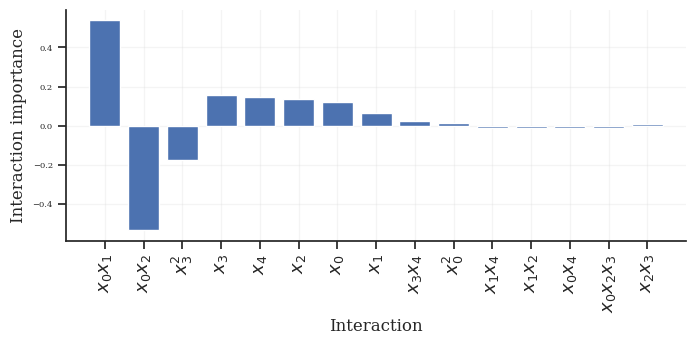

In [13]:
fig = es.plot_model_bar(n_features=15, magnitude=False, figsize=(8,3), show=False)
fig.gca().set_title('')
fig.gca().set_ylabel('Interaction importance')
fig.gca().tick_params(axis='x', which='major', labelsize=13)
plt.grid(alpha=0.2)
if save_figs:
    plt.savefig('./images/feature_importance_signed_artificial_strong_1dpd.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/feature_importance_signed_artificial_strong_1dpd.eps', bbox_inches='tight', facecolor='white')
plt.show()

# Compare feature interaction with H-statistic

In [14]:
f_names = [f'x{ind}' for ind in np.arange(n_feat)]
f_names_comb = list(itertools.combinations(f_names, r=2))
explainer = skexplain.ExplainToolkit(estimators=('svc', model), X=X_train, y=y_train, feature_names=f_names, estimator_output='probability')

In [15]:
# Calculate and time PDP and Friedman's H-statistic without subsampling
t_start = time.time()
pd_1d_ds = explainer.pd(features=f_names,
                        n_bootstrap=1,
                        subsample=1,
                        n_jobs=12,
                        n_bins=50, 
                        )

pd_2d_ds = explainer.pd(features=f_names_comb, n_bins=50, subsample=1, n_bootstrap=1, n_jobs=12)

hstat_results = explainer.friedman_h_stat(pd_1d=pd_1d_ds, pd_2d=pd_2d_ds, features=f_names_comb,)
print(f'Time for H-statistic explanations: {time.time() - t_start:.3e}s')

100%|██████████| 10/10 [00:00<00:00, 9988.82it/s]

Time for H-statistic explanations: 1.026e+02s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


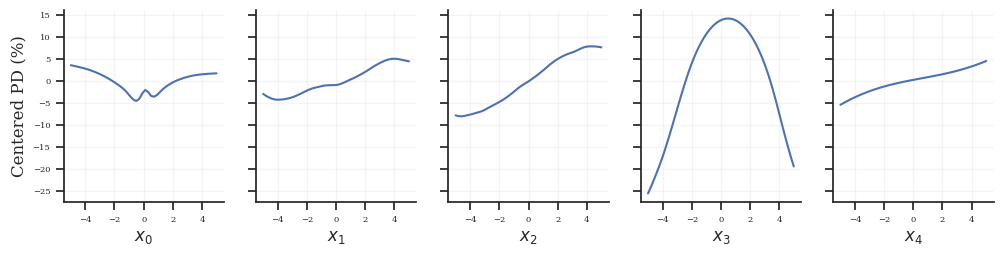

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


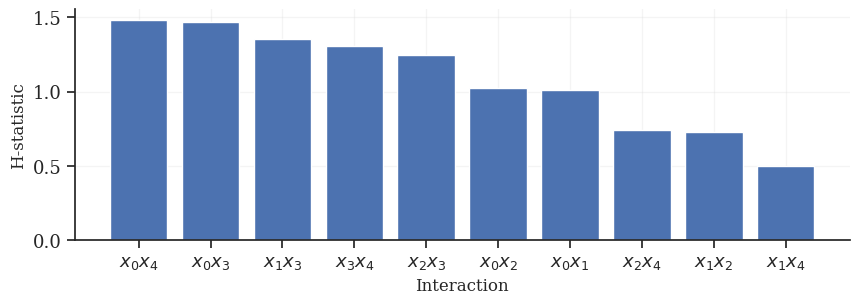

In [16]:
# Plot 1D PDP
fig, axs = plt.subplots(1, n_feat, figsize=(12,2.5), sharey=True)
for ifeat in np.arange(n_feat):
    x = pd_1d_ds[f'x{ifeat}__bin_values'].to_numpy().flatten()
    y = pd_1d_ds[f'x{ifeat}__svc__pd'].to_numpy().flatten()
    axs[ifeat].plot(x, 100*y)
    axs[ifeat].grid(alpha=0.2)
    axs[ifeat].set_xlabel(f'$x_{ifeat}$')
    if ifeat == 0:
        axs[ifeat].set_ylabel(f'Centered PD (%)')
if save_figs:
    plt.savefig('./images/pdp_1d_strong_1dpd.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/pdp_1d_strong_1dpd.eps', bbox_inches='tight', facecolor='white')
plt.show()

# Plot Friedman's H-statistic
rank = [f"$x_{interaction.split('__')[0][1:]}x_{interaction.split('__')[1][1:]}$" for interaction in list(hstat_results['hstat_rankings__svc'].to_numpy())]
val = hstat_results['hstat_scores__svc'].to_numpy().flatten()
plt.figure(figsize=(10,3))
plt.bar(np.arange(len(val)), val)
plt.xticks(np.arange(len(val)), labels=rank)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(alpha=0.2)
plt.xlabel('Interaction')
plt.ylabel('H-statistic')
if save_figs:
    plt.savefig('./images/h-statistic_strong_1dpd.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/h-statistic_strong_1dpd.eps', bbox_inches='tight', facecolor='white')
plt.show()

# Redo but with Scikit-Learn

In [18]:
n_bins = 50
pds_1d_d = {ind: np.zeros((n_bins)) for ind in lin_feat}
pds_1d_grid = {ind: np.zeros((n_bins)) for ind in lin_feat}

pds_2d_d = {f'{f_ind1},{f_ind2}': np.zeros((n_bins, n_bins)) for f_ind1, f_ind2 in itertools.combinations(lin_feat, r=2)}

# 2D PD
for f_ind1 in np.arange(n_feat):
    pd = partial_dependence(estimator=model, X=X_train, features=[f_ind1], grid_resolution=n_bins, response_method='predict_proba', percentiles=(0, 1))
    pds_1d_grid[str(f_ind1)] = pd['grid_values'][0]
    pds_1d_d[str(f_ind1)] = pd['average'][0]

    if f_ind1 < (n_feat-1):
        for f_ind2 in np.arange(f_ind1+1, n_feat):
            pd_2d = partial_dependence(estimator=model, X=X_train, features=[f_ind1, f_ind2], grid_resolution=n_bins, response_method='predict_proba', percentiles=(0, 1))
            pds_2d_d[f'{f_ind1},{f_ind2}'] = pd_2d['average'][0, :, :]

In [19]:
# Calculate H-statistics from 1 and 2D PD
def friedmans_hstat(X, pd_1d, pd_2d, grids, sort=False):

    int_2d = np.array(list(pd_2d.keys()))
    hstat_jk = np.zeros(len(int_2d))
    hstat_jk_nonnorm = np.zeros(len(int_2d))
    n_x = X.shape[0]
    # H-statistics between feature j and k
    for i, inds in enumerate(int_2d):
        f_ind1, f_ind2 = [int(ind) for ind in inds.split(',')]
        arr_j = pd_1d[str(f_ind1)]-np.mean(pd_1d[str(f_ind1)])
        arr_k = pd_1d[str(f_ind2)]-np.mean(pd_1d[str(f_ind2)])
        arr_jk = pd_2d[inds] - np.mean(pd_2d[inds])

        pd12_interp = interpn((grids[str(f_ind1)], grids[str(f_ind2)]), arr_jk.T, X_train[:, [f_ind1, f_ind2]], method='cubic')
        
        interp1 = interp1d(grids[str(f_ind1)], arr_j, kind='cubic')
        pd1_interp = interp1(X_train[:, f_ind1],)

        interp2 = interp1d(grids[str(f_ind2)], arr_k, kind='cubic')
        pd2_interp = interp2(X_train[:, f_ind2],)
        
        numerator = (pd12_interp - pd1_interp - pd2_interp)**2
        denominator = pd12_interp**2

        hstat_jk[i] = np.sqrt(np.sum(numerator)/np.sum(denominator))
        hstat_jk_nonnorm[i] = np.sqrt(np.sum(numerator))
    if sort:
        sort_order = np.argsort(hstat_jk)[::-1]
        hstat_jk = hstat_jk[sort_order]
        int_2d = int_2d[sort_order]
        hstat_jk_nonnorm = hstat_jk_nonnorm[sort_order]
    return int_2d, hstat_jk, hstat_jk_nonnorm

interaction, hstat, hstat_nonnorm = friedmans_hstat(X_train, pds_1d_d, pds_2d_d, pds_1d_grid, sort=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


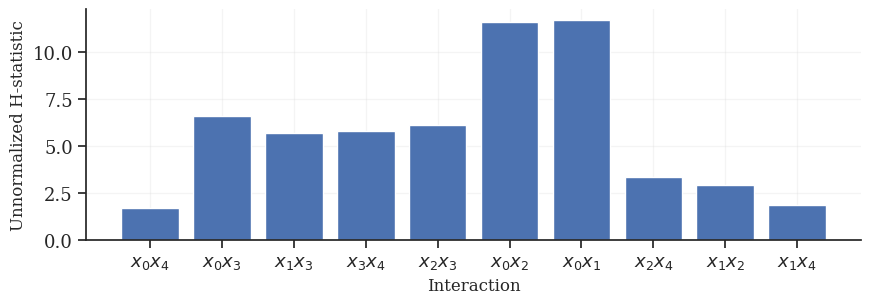

In [20]:
# Plot Friedman's H-statistic
plt.figure(figsize=(10,3))
plt.bar(np.arange(len(hstat_nonnorm)), hstat_nonnorm/hstat)
plt.xticks(np.arange(len(hstat_nonnorm)), interaction)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xticks(np.arange(len(hstat_nonnorm)), labels=rank)
plt.grid(alpha=0.2)
plt.xlabel('Interaction')
plt.ylabel('Unnormalized H-statistic')
if save_figs:
    plt.savefig('./images/h-statistic_nonnormalized_strong_1dpd.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/h-statistic_nonnormalized_strong_1dpd.eps', bbox_inches='tight', facecolor='white')
plt.show()